生成训练测试数据集：

In [1]:
import numpy as np
import random
import time

m = 10000
d = 200
k = 50

trains = np.zeros((m, d))
for i in range(m):
    trains[i] = np.array([random.gauss(0, 1) for z in range(d)])
test = np.array([random.gauss(0, 1) for z in range(d)])

print(trains.shape)

(10000, 200)


Python 实现 Annoy：

In [2]:
import numpy as np
from queue import PriorityQueue

def means(X):
    """
    启发式的选取两个点

    参数
    ----------
    X : 特征矩阵
    
    返回
    ----------
    两个向量点
    """
    iteration_steps = 20
    count = X.shape[0]
    i = np.random.randint(0, count)
    j = np.random.randint(0, count - 1)
    # 保证 i\j 不相同
    j += (j >= i)
    ic = 1
    jc = 1
    p = X[i]
    q = X[j]
    for l in range(iteration_steps):
        k = np.random.randint(0, count)
        di = ic * distance(p, X[k])
        dj = jc * distance(q, X[k])
        if di == dj:
            continue
        if di < dj:
            p = (p * ic + X[k]) / (ic + 1)
            ic = ic + 1
        else:
            q = (q * jc + X[k]) / (jc + 1)
            jc = jc + 1
    return p, q
        
def distance(a, b):
    """
    计算距离

    参数
    ----------
    a : 向量 a

    b : 向量 b
    
    返回
    ----------
    向量 a 与 向量 b 之间的距离
    """
    return np.linalg.norm(a - b)

class annoynode:
    """
    Annoy 树结点
    """
    
    def __init__(self, index, size, w, b, left = None, right = None):
        # 结点包含的样本点下标
        self.index = index
        # 结点及其子结点包含的样本数
        self.size = size
        # 分割超平面的系数
        self.w = w
        # 分割超平面的偏移量
        self.b = b
        # 左子树
        self.left = left
        # 右子树
        self.right = right
    
    def __lt__(self, other):
        # 结点大小比较
        return self.size < other.size

class annoytree:
    """
    Annoy 树算法实现
    
    参数
    ----------
    X : 特征矩阵

    leaf_size : 叶子节点包含的最大特征向量数量，默认为 10
    """
    
    def __init__(self, X, leaf_size = 10):
        def build_node(X_indexes):
            """
            构建结点
            
            参数
            ----------
            X_indexes : 特征矩阵下标
            """
            # 当特征矩阵小于等于指定的叶子结点的大小时，创建叶子结点并返回
            if len(X_indexes) <= leaf_size:
                return annoynode(X_indexes, len(X_indexes), None, None)
            # 当前特征矩阵
            _X = X[X_indexes, :]
            # 启发式的选取两点
            p, q = means(_X)
            # 超平面的系数
            w = p - q
            # 超平面的偏移量
            b = -np.dot((p + q) / 2, w)
            # 构建结点
            node = annoynode(None, len(X_indexes), w, b)
            # 在超平面“左”侧的特征矩阵下标
            left_index = (_X.dot(w) + b) > 0
            if left_index.any():
                # 递归的构建左子树
                node.left = build_node(X_indexes[left_index])
            # 在超平面“右”侧的特征矩阵下标
            right_index = ~left_index
            if right_index.any():
                # 递归的构建右子树
                node.right = build_node(X_indexes[right_index])
            return node
        # 根结点
        self.root = build_node(np.array(range(X.shape[0])))
        
class annoytrees:
    """
    Annoy 算法实现
    
    参数
    ----------
    X : 特征矩阵
    
    n_trees : Annoy 树的数量，默认为 10

    leaf_size : 叶子节点包含的最大特征向量数量，默认为 10
    """
    
    def __init__(self, X, n_trees = 10, leaf_size = 10):
        self._X = X
        self._trees = []
        # 循环的创建 Annoy 树
        for i in range(n_trees):
            self._trees.append(annoytree(X, leaf_size = leaf_size))
            
    def query(self, x, k = 1, search_k = -1):
        """
        查询距离最近 k 个特征向量

        参数
        ----------
        x : 目标向量

        k : 查询邻居数量

        search_k : 最少遍历出的邻居数量，默认为 Annoy 树的数量 * 查询数量
        """
        
        # 创建结点优先级队列
        nodes = PriorityQueue()
        # 先将所有根结点加入到队列中
        for tree in self._trees:
            nodes.put([float("inf"), tree.root])
        if search_k == -1:
            search_k = len(self._trees) * k
        # 待查询的邻居下标数组
        nns = []
        # 循环优先级队列
        while len(nns) < search_k and not nodes.empty():
            # 获取优先级最高的结点
            (dist, node) = nodes.get()
            # 如果是叶子结点，将下标数组加入待查询的邻居中
            if node.left is None and node.right is None:
                nns.extend(node.index)
            else:
                # 计算目标向量到结点超平面的距离
                dist = min(dist, np.abs(x.dot(node.w) + node.b))
                # 将距离做为优先级的结点加入到优先级队列中
                if node.left is not None:
                    nodes.put([dist, node.left])
                if node.right is not None:
                    nodes.put([dist, node.right])
        # 对下标数组进行排序
        nns.sort()
        prev = -1
        # 优先级队列
        nns_distance = PriorityQueue()
        for idx in nns:
            # 过滤重复的特征矩阵下标
            if idx == prev:
                continue
            prev = idx
            # 计算特征向量与目标向量的距离做为优先级
            nns_distance.put([distance(x, self._X[idx]), idx])
        nearests = []
        distances = []
        # 取前 k 个
        for i in range(k):
            if nns_distance.empty():
                break
            (dist, idx) = nns_distance.get()
            nearests.append(idx)
            distances.append(dist)
        return nearests, distances

Annoy 构建与查询：

In [3]:
from annoy import AnnoyIndex

start = time.time()
# 初始化 AnnoyIndex，使用欧式距离
t = AnnoyIndex(d, 'euclidean')
for i in range(m):
    # 添加样本点
    t.add_item(i, trains[i])
# 构建 20 棵二叉树
t.build(20)
cost = time.time() - start
print("Annoy Build: ", cost)

start = time.time()
# 查询 test 点最近 k 个样本点
nearests, distances = t.get_nns_by_vector(test, k, include_distances=True)
cost = time.time() - start
print("Annoy Search: ", cost)
print("Indexes: ", np.array(nearests))
print("Distances: ", np.array(distances))

Annoy Build:  0.17376995086669922
Annoy Search:  0.0003261566162109375
Indexes:  [2087 2955 2820 5860 4858 5183 3419 3120 8935  469 2795 6300 4401  220
 2491  322 2130 4204 1069 7695 3611 7304 3229 3546 6951  948 2653 3541
 8488 5504 2233 7134 5726 7599 8718 1936 4895 6350 4688 9304 2724 2305
 4615 3241 7749 1851 1433  514 8820 2685]
Distances:  [17.03445244 17.074543   17.23371887 17.29202843 17.3838768  17.38926888
 17.39016724 17.42239571 17.43660164 17.43716049 17.44219589 17.46596336
 17.46749687 17.48422623 17.49925041 17.50570679 17.5290432  17.58576202
 17.58647156 17.59267235 17.59703255 17.61027718 17.6764679  17.67796135
 17.69918251 17.71703529 17.7469635  17.77556801 17.77716064 17.79926109
 17.80227661 17.80312729 17.81699371 17.83490944 17.87693596 17.88405037
 17.88469887 17.88484573 17.90133476 17.91887474 17.92709732 17.9437542
 17.96082115 17.97278595 17.98053169 17.98347473 18.00175476 18.0065403
 18.01778221 18.0187149 ]


Ball Tree 构建与查询：

In [4]:
from sklearn.neighbors import BallTree

start = time.time()
tree = BallTree(trains)
cost = time.time() - start
print("Ball Tree Build: ", cost)

start = time.time()
distances, nearests = tree.query(np.array([test]), k)
cost = time.time() - start
print("Ball Tree Search: ", cost)
print("Indexes: ", nearests[0])
print("Distances: ", distances[0])

Ball Tree Build:  0.07265377044677734
Ball Tree Search:  0.003065824508666992
Indexes:  [1982 8244 2150 2087 7455 5220 4507 7382 2955 2938 8253  269 1891 2820
 2435 5860 2729 1767 9968 7977 3578 5488 5032  254 4858 5183 5107 3419
 1034 5208  822 3120 7765 8935  469 2941 2795 2564 6300 5096 4401 1490
 3919 6312 4282 6407  220 6676 6910 7415]
Distances:  [16.89884757 16.96648838 17.01921737 17.03445208 17.04229582 17.04643241
 17.05813518 17.07179647 17.07454464 17.12051775 17.14960123 17.18627548
 17.22199311 17.23371743 17.24356866 17.29202753 17.30379704 17.30954783
 17.31187673 17.32290499 17.32307655 17.36471041 17.37858653 17.38091254
 17.38387616 17.3892679  17.39015788 17.39016637 17.40299881 17.41015991
 17.4151256  17.42239582 17.42578051 17.43660148 17.43716072 17.4372148
 17.44219691 17.46312689 17.46596197 17.46743996 17.46749663 17.46862695
 17.46926795 17.47576712 17.47624183 17.47633038 17.48422532 17.48533048
 17.48934812 17.49741322]


python 实现构建与查询：

In [5]:
at = annoytrees(trains, 20)
nearests, distances = at.query(test, k)
print("Indexes: ", np.array(nearests))
print("Distances: ", np.array(distances))

Indexes:  [5220 2955 7977 5032 1034 7415 9406 4012 1069 8811 2081 3851 1936 4084
 7668 1992  514 6796 4675 1916  517 4380 5446 6020 7681 4271 4878 9438
 9095 8229  202 7945 6700 9719 5937 5313 3802 7043 2083  222 4437 6515
 1430 3959 7935 9424 2671  866 5316 4408]
Distances:  [17.04643241 17.07454464 17.32290499 17.37858653 17.40299881 17.49741322
 17.5387657  17.54287361 17.58647167 17.61416024 17.65120569 17.83754937
 17.88404998 17.92391482 17.98436859 18.00448112 18.00654011 18.02729789
 18.04183201 18.06602622 18.09846612 18.10092578 18.13414213 18.13613252
 18.15330249 18.1656789  18.17441276 18.1784536  18.17989569 18.20001631
 18.20619473 18.23051494 18.24594438 18.26846985 18.27265548 18.27894962
 18.28403095 18.3032248  18.30631446 18.31198453 18.3244178  18.32679832
 18.33354389 18.35832998 18.36840283 18.36974737 18.37060299 18.38133618
 18.38979675 18.39271755]


平衡二叉树演示：

<IPython.core.display.Javascript object>


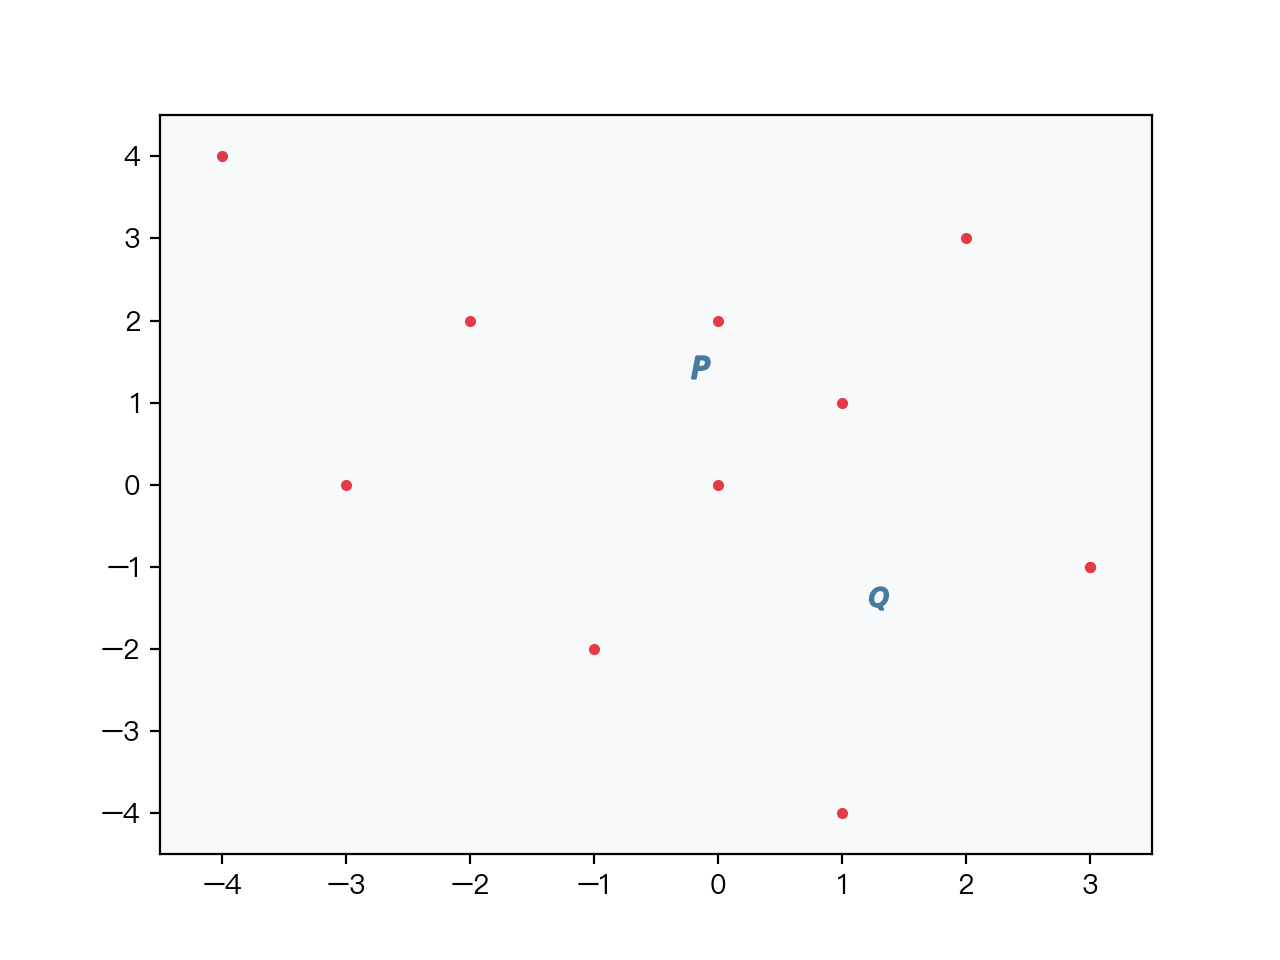

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib notebook

def means_step(X, iteration_steps = 200):
    count = X.shape[0]
    i = np.random.randint(0, count)
    j = np.random.randint(0, count - 1)
    j += (j >= i)
    ic = 1
    jc = 1
    p = X[i]
    q = X[j]
    ps = np.zeros((iteration_steps, len(p)))
    qs = np.zeros((iteration_steps, len(q)))
    ts = np.zeros((iteration_steps, len(q)))
    for l in range(iteration_steps):
        p, q, ic, jc, _ = step(X, p, q, ic, jc)
        ps[l], qs[l], ts[l] = p, q, _
    return ps, qs, ts

def step(X, p, q, ic, jc):
    k = np.random.randint(0, X.shape[0])
    di = ic * distance(p, X[k])
    dj = jc * distance(q, X[k])
    if di == dj:
        return
    if di < dj:
        p = (p * ic + X[k]) / (ic + 1)
        ic = ic + 1
    else:
        q = (q * jc + X[k]) / (jc + 1)
        jc = jc + 1
    return p, q, ic, jc, X[k]

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

np.random.seed(0)
X = np.array([[1,1], [2,3], [3,-1], [0,0], [-1,-2], [-2, 2], [-4, 4], [3,-1], [1, -4],[0,2], [-3, 0]])
itr = 50
ps, qs, ts = means_step(X, iteration_steps = itr)
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
x1 = X[:, 0]
y1 = X[:, 1]
plt.scatter(x1, y1, c='#e63946', marker='.')

p = plt.scatter(ps[0][0], ps[0][1], c='#457b9d', marker='$P$', s=60)
q = plt.scatter(qs[0][0], qs[0][1], c='#457b9d', marker='$Q$', s=60)
t = plt.scatter(ts[0][0], ts[0][1], c='#457b9d', marker='$T$', s=60)

def update(i):
    p.set_offsets(ps[i])
    q.set_offsets(qs[i])
    if i + 1 < itr:
        t.set_offsets(ts[i + 1])
    else:
        t.set_offsets([10, 10])
    return p, q, t

ani = animation.FuncAnimation(fig, update, range(1, itr), interval=500, blit=True, repeat=False)
ani.save('means.gif')
plt.show()